In [80]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from datetime import datetime
from math import radians, cos, sin, sqrt, atan2, degrees
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [53]:
df = pd.read_csv("ais.csv")
df

,lat,lon,date,ID
0,38.10147,-122.26952,2020-12-31T00:00:00,366989380
1,32.71527,-117.17972,2020-12-31T00:00:00,366685950
2,41.66363,-87.58109,2020-12-31T00:00:00,367463740
3,32.34337,-117.63240,2020-12-31T00:00:00,354277000
4,33.46530,-118.48131,2020-12-31T00:00:00,376162280
...,...,...,...,...
1048570,40.63305,-74.20236,2020-12-31T03:42:13,636013274
1048571,34.18450,-77.95667,2020-12-31T03:42:13,308695000
1048572,41.14392,-73.89121,2020-12-31T03:42:13,338862000
1048573,17.99635,-66.77203,2020-12-31T03:42:13,368669000


In [54]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])
# Sort DataFrame by date
df = df.sort_values(by=['ID','date'])


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048575 entries, 5305 to 1039725
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   lat     1048575 non-null  float64       
 1   lon     1048575 non-null  float64       
 2   date    1048575 non-null  datetime64[ns]
 3   ID      1048575 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 40.0 MB


In [35]:
df=df.dropna()

In [44]:
# Helper function to calculate Haversine distance between two lat/lon pairs
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles.
    return c * r

# Function to calculate the bearing between two points
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = sin(dlon) * cos(lat2)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dlon)
    initial_bearing = atan2(x, y)
    initial_bearing = degrees(initial_bearing)
    bearing = (initial_bearing + 360) % 360
    return bearing


# Compute shifted latitude, longitude, and date for difference calculation
df['shifted_lat'] = df.groupby('ID')['lat'].shift()
df['shifted_lon'] = df.groupby('ID')['lon'].shift()
df['shifted_date'] = df.groupby('ID')['date'].shift()

# Initialize columns for distance, speed, and direction
df['distance_km'] = 0.0
df['speed_kmh'] = 0.0
df['direction'] = 0.0

# Iterate over DataFrame rows to calculate distance, speed and direction
for index, row in df.iterrows():
    if pd.notnull(row['shifted_date']) and pd.notnull(row['shifted_lat']) and pd.notnull(row['shifted_lon']):
        # Calculate distance
        distance = haversine(row['lon'], row['lat'], row['shifted_lon'], row['shifted_lat'])
        df.at[index, 'distance_km'] = distance
        
        # Calculate time difference in hours
        time_diff_hours = (row['date'] - row['shifted_date']).total_seconds() / 3600
        if time_diff_hours > 0:
            # Calculate speed
            speed = distance / time_diff_hours
            df.at[index, 'speed_kmh'] = speed
        
        # Calculate direction
        direction = calculate_bearing(row['shifted_lat'], row['shifted_lon'], row['lat'], row['lon'])
        df.at[index, 'direction'] = direction

# Drop the temporary shifted columns
df.drop(columns=['shifted_lat', 'shifted_lon', 'shifted_date'], inplace=True)

# You can now display the DataFrame or do further analysis
df.head()



,lat,lon,date,ID,distance_km,speed_kmh,direction
5305,21.31639,-157.87734,2020-12-31 00:00:59,0,0.0,0.0,0.0
20935,21.31639,-157.87734,2020-12-31 00:04:02,0,0.0,0.0,0.0
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,0.0,0.0,0.0
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,0.0,0.0,0.0
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,0.0,0.0,0.0


In [45]:
df.tail()

,lat,lon,date,ID,distance_km,speed_kmh,direction
911912,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,0.000926,0.018624,270.000003
970035,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,0.002160,0.010369,239.020423
998090,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,0.001447,0.014471,39.787930
1026094,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,0.000926,0.009209,89.999997
1039725,33.61133,-117.92657,2020-12-31 03:40:19,1072211352,0.000926,0.018729,270.000003


In [31]:
df

,lat,lon,date,ID,distance,speed,direction
5305,21.31639,-157.87734,2020-12-31 00:00:59,0,NaN,NaN,NaN
20935,21.31639,-157.87734,2020-12-31 00:04:02,0,0.0,0.0,NaN
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,NaN,NaN,NaN
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,NaN,NaN,NaN
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
911912,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,NaN,NaN,NaN
970035,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,NaN,NaN,NaN
998090,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,NaN,NaN,NaN
1026094,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,NaN,NaN,NaN


In [59]:
# Assuming df is your DataFrame and that 'date' is already a datetime64 type.

# Calculate the diffs required for the operations
df['shifted_lat'] = df.groupby('ID')['lat'].shift()
df['shifted_lon'] = df.groupby('ID')['lon'].shift()
df['time_diff'] = df['date'].diff().dt.total_seconds().div(60)  # Time diff in hours

# Vectorized implementation of the Haversine formula
def vectorized_haversine(lon1, lat1, lon2, lat2):
    # Convert to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# Calculate distances using the vectorized function
df['distance_km'] = vectorized_haversine(df['shifted_lon'], df['shifted_lat'], df['lon'], df['lat'])

# Calculate speeds: distance/time
df['speed_kmh'] = df['distance_km'] / df['time_diff']  # Speed in km/h

# Ensure we're not dividing by zero
df['speed_kmh'] = df['speed_kmh'].replace(np.inf, np.nan)

# Define a vectorized function for bearing
def vectorized_bearing(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Bearing calculation
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    initial_bearing = np.arctan2(x, y)
    # Convert from radians to degrees and adjust to 0-360 scale
    return np.degrees(initial_bearing) % 360

# Calculate bearing using the vectorized function
df['direction'] = np.where(pd.notna(df['shifted_lon']), 
                         vectorized_bearing(df['shifted_lat'], df['shifted_lon'], df['lat'], df['lon']), 
                         np.nan)

# Clean up: drop temporary columns and NA values that arose from shifting
df.drop(['shifted_lat', 'shifted_lon'], axis=1, inplace=True)
df.dropna(subset=['direction', 'speed_kmh', 'distance_km'], inplace=True)

In [60]:
df

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.000000,0.000000,0.000000
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.000000,0.000000,0.000000
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.000000,0.000000,0.000000
78504,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.000000,0.000000,0.000000
93409,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
911912,33.61133,-117.92656,2020-12-31 03:12:49,1072211352,2.983333,0.000926,0.000310,270.000003
970035,33.61132,-117.92658,2020-12-31 03:25:19,1072211352,12.500000,0.002160,0.000173,239.020423
998090,33.61133,-117.92657,2020-12-31 03:31:19,1072211352,6.000000,0.001447,0.000241,39.787930
1026094,33.61133,-117.92656,2020-12-31 03:37:21,1072211352,6.033333,0.000926,0.000153,89.999997


In [61]:
column_names = df.columns.tolist()
column_names

['lat',
 'lon',
 'date',
 'ID',
 'time_diff',
 'distance_km',
 'speed_kmh',
 'direction']

In [65]:
df[df['ID'] == 0]

,lat,lon,date,ID,time_diff,distance_km,speed_kmh,direction
35066,21.31639,-157.87734,2020-12-31 00:07:04,0,3.033333,0.0,0.0,0.0
49570,21.31639,-157.87734,2020-12-31 00:10:07,0,3.050000,0.0,0.0,0.0
64549,21.31639,-157.87734,2020-12-31 00:13:09,0,3.033333,0.0,0.0,0.0
78504,21.31639,-157.87734,2020-12-31 00:16:12,0,3.050000,0.0,0.0,0.0
93409,21.31639,-157.87734,2020-12-31 00:19:14,0,3.033333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
981448,21.31639,-157.87735,2020-12-31 03:27:45,0,3.050000,0.0,0.0,0.0
995683,21.31639,-157.87735,2020-12-31 03:30:47,0,3.033333,0.0,0.0,0.0
1009900,21.31639,-157.87735,2020-12-31 03:33:50,0,3.050000,0.0,0.0,0.0
1023791,21.31639,-157.87735,2020-12-31 03:36:52,0,3.033333,0.0,0.0,0.0


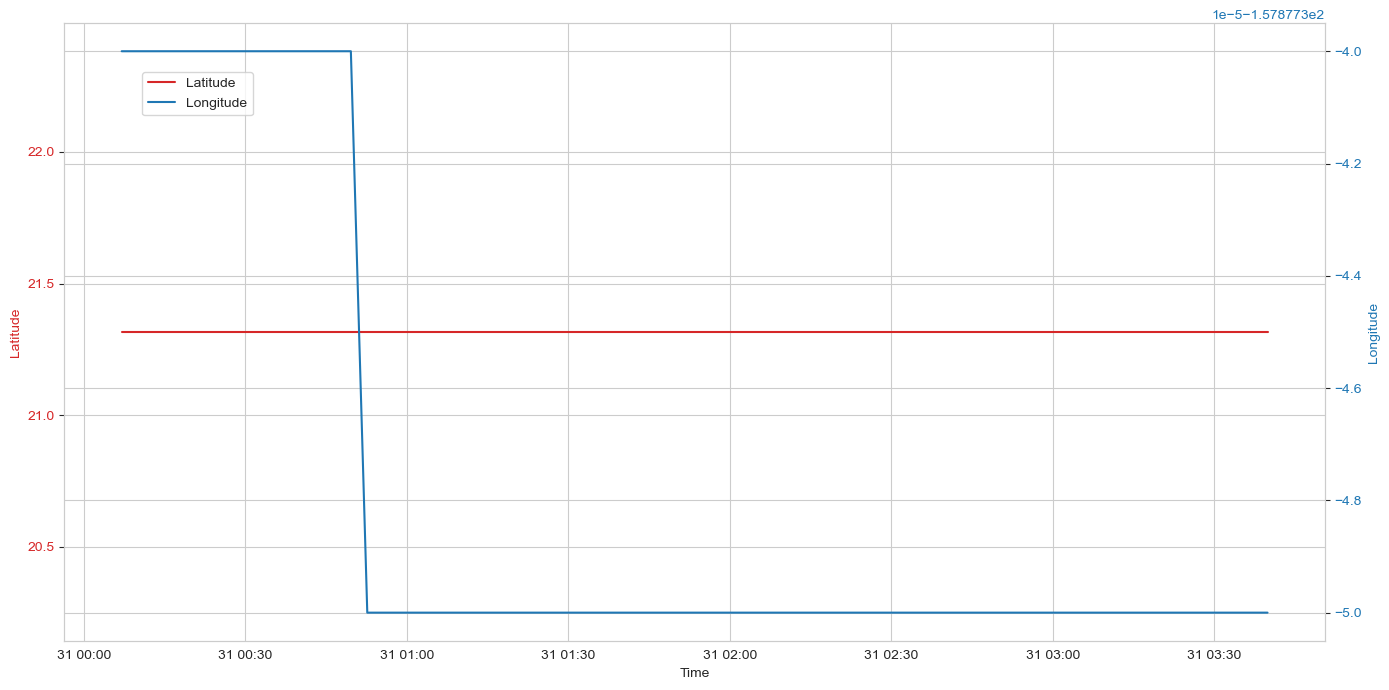

In [76]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and you have an 'ID' column
def plot_data_for_id(dataframe, id_value):
    # Filter the DataFrame for the ID of interest
    df_filtered = dataframe[dataframe['ID'] == id_value]
    
    # Sort the filtered data by date to ensure a proper time-series plot
    df_filtered = df_filtered.sort_values(by='date')
    
    # Check if there's data to plot
    if df_filtered.empty:
        print(f"No data found for ID {id_value}")
        return
    
    # Plotting example: assuming you want to plot latitude and longitude over time
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot latitude
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Latitude', color='tab:red')
    ax1.plot(df_filtered['date'], df_filtered['lat'], color='tab:red', label='Latitude')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for the longitude data
    ax2 = ax1.twinx()
    ax2.set_ylabel('Longitude', color='tab:blue') 
    ax2.plot(df_filtered['date'], df_filtered['lon'], color='tab:blue', label='Longitude')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # If you want a legend to appear:
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    
    # Show the plot
    plt.show()

# Call the function with the ID you are interested in
plot_data_for_id(df, 0)

C:\Users\o.kazemi\AppData\Local\mambaforge\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


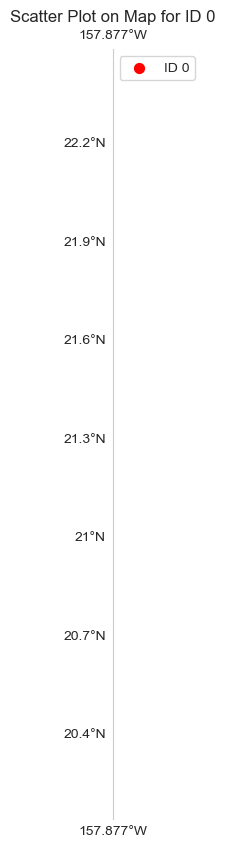

In [81]:
# Function to plot data on an offline map using Cartopy
def plot_on_map(df, id_value):
    # Filter the DataFrame for the ID
    df_filtered = df[df['ID'] == id_value]
    
    # Check if there is any data to plot
    if df_filtered.empty:
        print(f"No data found for ID {id_value}")
        return
    
    # Create a plot with a specific projection
    fig, ax = plt.subplots(figsize=(10, 10),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()

    # Plot the points on the map with 'o' markers
    scatter = ax.scatter(df_filtered['lon'], df_filtered['lat'], s=50, color='red', marker='o', 
                         label=f"ID {id_value}", transform=ccrs.Geodetic())

    # Set the extent of the map view if necessary, this can be set to the range of your input data
    # ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude])
    
    # Optionally, add gridlines
    ax.gridlines(draw_labels=True)

    plt.legend(loc='upper left')
    plt.title(f"Scatter Plot on Map for ID {id_value}")

    plt.show()

# Call the function with the dataframe and a specific ID.
plot_on_map(df, 0)

In [98]:
import folium
from folium.plugins import MarkerCluster

# Function to plot data on an online folium map.
def plot_on_online_folium_map(df, id_value):
    # Filter the dataset for the ID.
    df_filtered = df[df['ID'] == id_value]
    
    # Check if there's data to plot.
    if df_filtered.empty:
        print(f"No data found for ID {id_value}")
        return None

    # Create a Map instance
    m = folium.Map(location=[df_filtered['lat'].mean(), df_filtered['lon'].mean()],
                   zoom_start=13)
    
    # Create and add a MarkerCluster to the map.
    marker_cluster = MarkerCluster().add_to(m)

    # Add markers to the MarkerCluster
    for idx, row in df_filtered.iterrows():
        folium.Marker(location=[row['lat'], row['lon']], popup=f'ID: {id_value}, Index: {idx}').add_to(marker_cluster)
    
    # Display the map
    return m

# Replace 'your_id' with the actual ID value you want to plot
# Plot the data for the ID on an online folium map.
online_map = plot_on_online_folium_map(df, 0)

# If running in a Jupyter notebook environment, display the map inline
online_map

In [91]:
df["ID"].unique().tolist()

[0,
 12,
 270995,
 368926,
 507027,
 737255,
 3660489,
 3660503,
 9110192,
 12345678,
 36690000,
 99150794,
 122292919,
 123456789,
 155017179,
 200000000,
 205706000,
 205760000,
 207832820,
 209016000,
 209162000,
 209414000,
 209438000,
 209504000,
 209513000,
 209550000,
 209641000,
 209729000,
 209862000,
 209933000,
 210102000,
 210296000,
 210347000,
 210520410,
 210562000,
 210638000,
 210886000,
 210959000,
 211002010,
 211111111,
 211331640,
 211433000,
 211705870,
 211744000,
 211779000,
 211839000,
 212001111,
 212040000,
 212254000,
 212348000,
 212384000,
 212438000,
 212452000,
 214182695,
 214182782,
 215000394,
 215004000,
 215035000,
 215126000,
 215131000,
 215181000,
 215193000,
 215197000,
 215233000,
 215240000,
 215251000,
 215322000,
 215434000,
 215464000,
 215532000,
 215558000,
 215677000,
 215800000,
 215871000,
 218063000,
 218352000,
 218441000,
 218643000,
 219028015,
 219028040,
 219056000,
 219151000,
 219208000,
 219256000,
 219349000,
 219353000,
 219

In [100]:
df.to_csv("ais_fixed1.csv",index=False)